# Manhattan Commercial Real Estate Analysis

**DataFest 2025 Project**

This notebook documents our analysis of Manhattan commercial real estate leasing data. We built a buyer-side exploration tool that helps prospective tenants find office space based on their needs.

## Project Overview

**Objective:** Create a data-driven tool for commercial tenants to find optimal office space in Manhattan.

**Key Features:**
- Filter properties by square footage, safety, and transit accessibility
- Visualize market friendliness by industry sector
- Estimate annual rent based on building class and size

**Data Sources:**
- CoStar lease transaction data (~195K records across US markets)
- NYC crime data for safety scoring
- Transit route data for accessibility scoring
- Business establishment data for sector analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'

## 1. Data Loading & Exploration

Let's start by examining the raw lease data.

In [2]:
# Load raw lease data
leases_raw = pd.read_csv(RAW_DIR / 'Leases.csv')
print(f"Total records: {len(leases_raw):,}")
print(f"\nColumns: {list(leases_raw.columns)}")
leases_raw.head()

Total records: 194,685

Columns: ['year', 'quarter', 'monthsigned', 'market', 'building_name', 'building_id', 'address', 'region', 'city', 'state', 'zip', 'internal_submarket', 'internal_class', 'leasedSF', 'company_name', 'internal_industry', 'transaction_type', 'internal_market_cluster', 'costarID', 'space_type', 'CBD_suburban', 'RBA', 'available_space', 'availability_proportion', 'internal_class_rent', 'overall_rent', 'direct_available_space', 'direct_availability_proportion', 'direct_internal_class_rent', 'direct_overall_rent', 'sublet_available_space', 'sublet_availability_proportion', 'sublet_internal_class_rent', 'sublet_overall_rent', 'leasing']


,year,quarter,monthsigned,market,building_name,building_id,address,region,city,state,...,overall_rent,direct_available_space,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing
0,2018,Q1,1.0,Atlanta,10 Glenlake North Tower,Atlanta_Central Perimeter_Atlanta_10 Glenlake ...,10 Glenlake Pky NE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
1,2018,Q1,1.0,Atlanta,100 City View,Atlanta_Northwest_Atlanta_100 City View_3330 C...,3330 Cumberland Blvd,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
2,2018,Q1,1.0,Atlanta,1000 Parkwood,Atlanta_Northwest_Atlanta_1000 Parkwood_1000 P...,1000 Parkwood Cir SE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0
3,2018,Q1,1.0,Atlanta,1100 Circle 75,Atlanta_Northwest_Atlanta_1100 Circle 75_1100 ...,1100 Circle 75 Pky SE,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715742.0
4,2018,Q1,1.0,Atlanta,1200 Ashwood,Atlanta_Central Perimeter_Atlanta_1200 Ashwood...,1200 Ashwood Pky,South,Atlanta,GA,...,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126.0


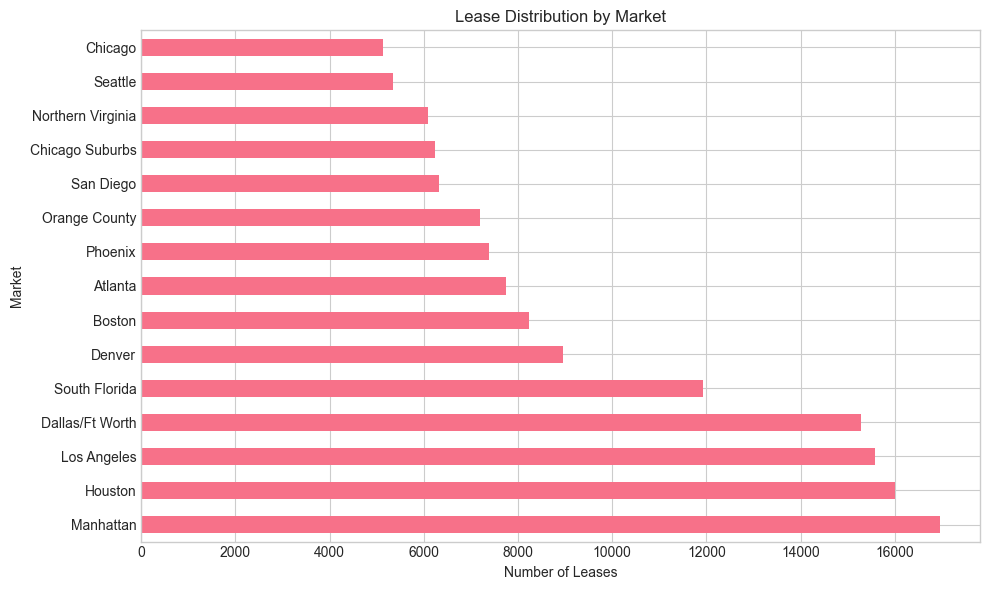


Manhattan leases: 16,961


In [3]:
# Check market distribution
market_counts = leases_raw['market'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(10, 6))
market_counts.plot(kind='barh', ax=ax)
ax.set_xlabel('Number of Leases')
ax.set_ylabel('Market')
ax.set_title('Lease Distribution by Market')
plt.tight_layout()
plt.show()

print(f"\nManhattan leases: {leases_raw['market'].str.contains('Manhattan', case=False, na=False).sum():,}")

## 2. Data Filtering: Manhattan Focus

We focus on Manhattan as it has:
- Highest lease activity
- Most diverse tenant mix
- Best data coverage

In [4]:
# Filter to Manhattan
manhattan = leases_raw[
    leases_raw['market'].str.contains('Manhattan', case=False, na=False) |
    leases_raw['city'].str.contains('New York', case=False, na=False)
].copy()

# Clean up
manhattan = manhattan[
    (manhattan['address'].notna()) & 
    (manhattan['address'] != '') &
    (manhattan['leasedSF'].notna()) & 
    (manhattan['leasedSF'] > 0)
]

print(f"Manhattan leases after cleaning: {len(manhattan):,}")
manhattan.describe()

Manhattan leases after cleaning: 16,961


,year,monthsigned,zip,leasedSF,costarID,RBA,available_space,availability_proportion,internal_class_rent,overall_rent,direct_available_space,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing
count,16961.000000,16870.000000,16961.000000,1.696100e+04,1.696100e+04,1.696000e+04,1.696000e+04,16960.000000,16960.000000,16960.000000,1.407400e+04,14074.000000,14074.000000,14074.000000,1.407400e+04,14074.000000,14074.000000,14074.000000,1.696000e+04
mean,2021.030835,6.387137,10028.095101,1.308546e+04,4.457417e+05,2.186126e+08,3.446650e+07,0.156650,69.506338,77.400723,2.841912e+07,0.061147,73.190837,82.405244,8.395818e+06,0.018063,56.259464,60.139622,3.867485e+06
std,2.114066,3.434115,44.815531,4.375948e+04,1.560008e+06,2.816969e+07,1.093458e+07,0.042327,11.486246,2.949376,8.081629e+06,0.016858,13.817941,2.460724,2.698907e+06,0.005670,6.479980,2.092867,1.406451e+06
min,2018.000000,1.000000,10001.000000,1.000000e+00,2.627000e+03,1.964154e+08,1.816511e+07,0.090814,60.033350,73.739864,1.340337e+07,0.029500,61.100992,79.852772,4.078449e+06,0.009100,44.825281,57.548437,9.938860e+05
25%,2019.000000,3.000000,10010.000000,1.997000e+03,1.571590e+05,1.998705e+08,2.075680e+07,0.103851,61.493221,75.887677,2.394102e+07,0.052700,63.940167,80.652660,6.254306e+06,0.013800,51.249825,58.708796,3.018586e+06
50%,2021.000000,6.000000,10017.000000,4.350000e+03,1.574220e+05,2.003958e+08,3.712976e+07,0.181430,62.316702,76.625951,2.926288e+07,0.062300,64.990536,81.800437,8.200482e+06,0.017400,55.958021,59.319707,3.576615e+06
75%,2023.000000,9.000000,10022.000000,1.025800e+04,1.578610e+05,2.474741e+08,3.951836e+07,0.194883,84.635545,77.616713,3.313330e+07,0.071100,91.560214,82.769759,9.078405e+06,0.019900,62.207832,61.012123,4.461053e+06
max,2024.000000,12.000000,10285.000000,1.463234e+06,1.932442e+07,2.683833e+08,5.457790e+07,0.203839,94.191224,84.746663,4.092899e+07,0.086900,99.642941,88.438174,1.435339e+07,0.030700,68.067085,65.436381,9.393220e+06


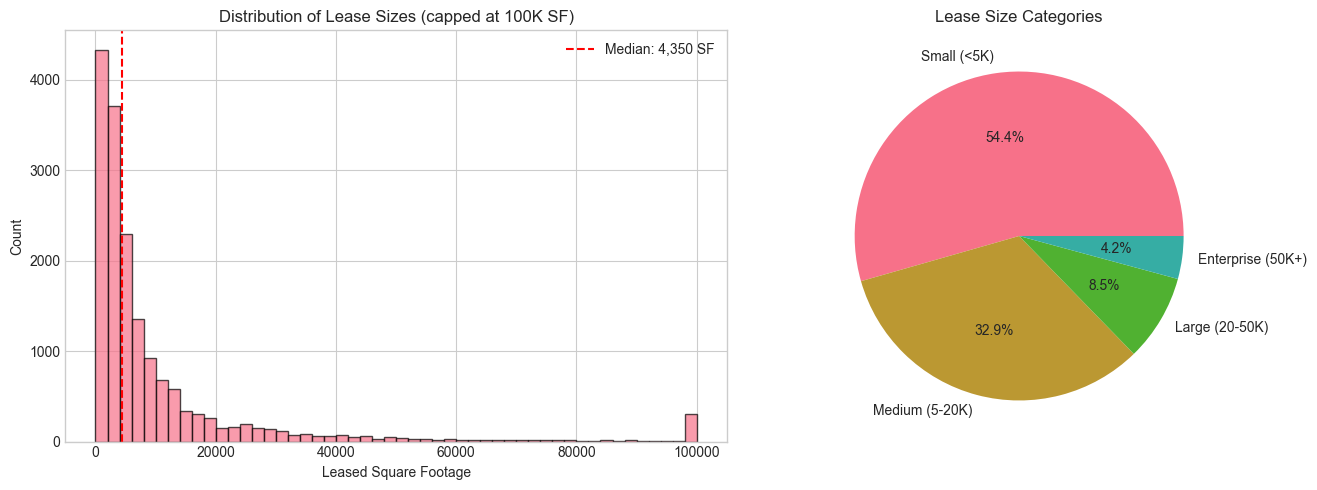

In [5]:
# Lease size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(manhattan['leasedSF'].clip(upper=100000), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Leased Square Footage')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Lease Sizes (capped at 100K SF)')
axes[0].axvline(manhattan['leasedSF'].median(), color='red', linestyle='--', label=f"Median: {manhattan['leasedSF'].median():,.0f} SF")
axes[0].legend()

# Box plot by size category
manhattan['size_cat'] = pd.cut(
    manhattan['leasedSF'], 
    bins=[0, 5000, 20000, 50000, float('inf')],
    labels=['Small (<5K)', 'Medium (5-20K)', 'Large (20-50K)', 'Enterprise (50K+)']
)
manhattan['size_cat'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Lease Size Categories')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Industry Analysis

Which industries lease the most space in Manhattan?

In [6]:
# Industry breakdown
industry_stats = manhattan.groupby('internal_industry').agg({
    'leasedSF': ['count', 'sum', 'mean', 'median']
}).round(0)

industry_stats.columns = ['Lease Count', 'Total SF', 'Avg SF', 'Median SF']
industry_stats = industry_stats.sort_values('Total SF', ascending=False)

print("Top Industries by Total Leased SF:")
industry_stats.head(10)

Top Industries by Total Leased SF:


,Lease Count,Total SF,Avg SF,Median SF
internal_industry,,,,
Financial Services and Insurance,1400,50761415.0,36258.0,15524.0
"Technology, Advertising, Media, and Information",868,38669304.0,44550.0,16910.0
Legal Services,393,17974671.0,45737.0,18158.0
Retail,401,11999884.0,29925.0,15109.0
Coworking and Executive Suite Companies,193,8970262.0,46478.0,33192.0
"Business, Professional, and Consulting Services (except Financial and Legal) - Including Accounting",425,8912133.0,20970.0,12083.0
Government,78,5802217.0,74387.0,42500.0
Associations and Non-profit Organizations (except Education and Non-profit Hospitals),201,4838126.0,24070.0,13801.0
Healthcare,111,3911249.0,35236.0,12228.0


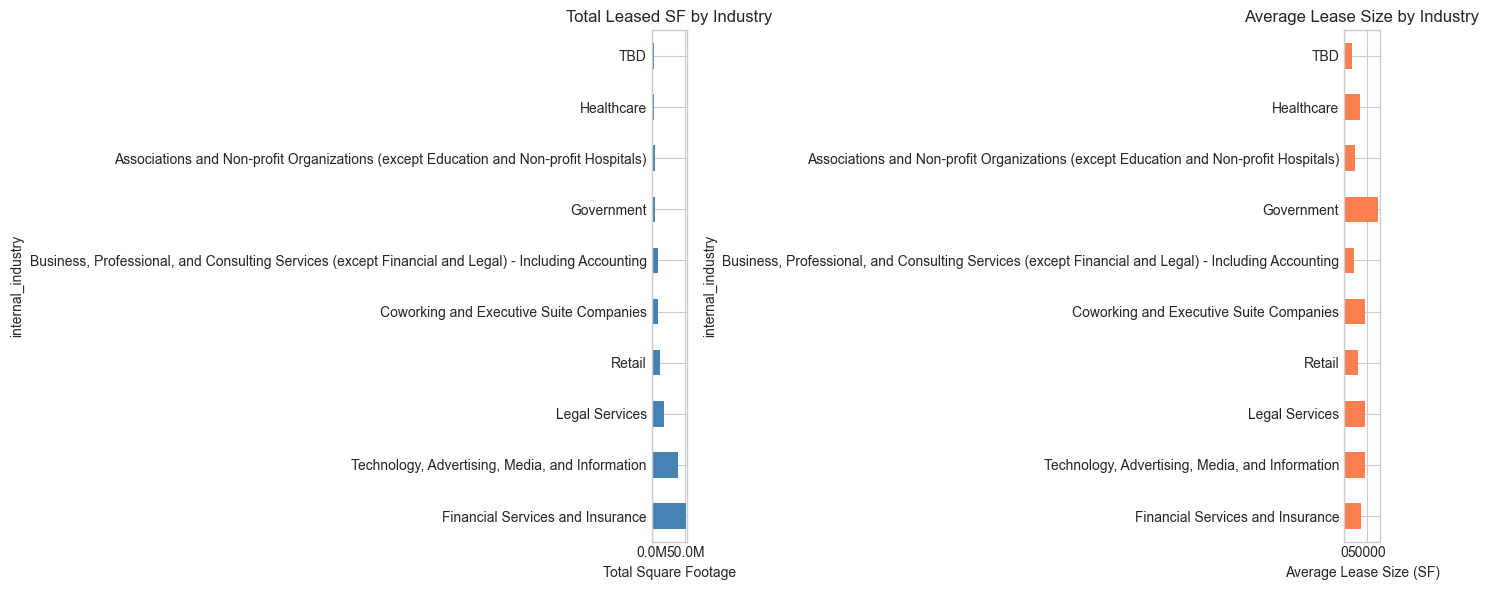

In [7]:
# Visualize top industries
top_industries = industry_stats.head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total SF
top_industries['Total SF'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Total Square Footage')
axes[0].set_title('Total Leased SF by Industry')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Average lease size
top_industries['Avg SF'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_xlabel('Average Lease Size (SF)')
axes[1].set_title('Average Lease Size by Industry')

plt.tight_layout()
plt.show()

## 4. Building Class Analysis

Commercial buildings are classified as:
- **Class A**: Premium buildings with best amenities and locations
- **Class B/O**: Standard buildings with moderate features

Lease Statistics by Building Class:
                Count     Total SF   Avg SF
internal_class                             
A                5202  136979220.0  26332.0
O               11758   84962815.0   7226.0


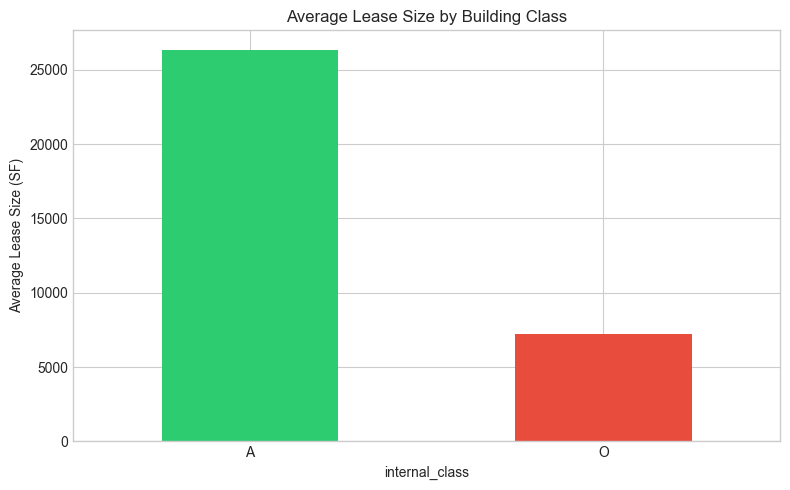

In [8]:
# Building class breakdown
if 'internal_class' in manhattan.columns:
    class_stats = manhattan.groupby('internal_class').agg({
        'leasedSF': ['count', 'sum', 'mean']
    }).round(0)
    class_stats.columns = ['Count', 'Total SF', 'Avg SF']
    
    print("Lease Statistics by Building Class:")
    print(class_stats)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    class_stats['Avg SF'].plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
    ax.set_ylabel('Average Lease Size (SF)')
    ax.set_title('Average Lease Size by Building Class')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

## 5. Pricing Model

We developed a pricing model based on:
- Base market rent rate
- Building class premiums/discounts
- Volume discounts for large leases

### Model Parameters:
| Factor | Value |
|--------|-------|
| Base Rate | $75.09/SF |
| Class A Premium | +20% |
| Class O Discount | -20% |
| Bulk Discount (>50K SF) | -7% |

In [9]:
# Pricing model implementation
BASE_RATE = 75.09
CLASS_A_MULT = 1.20
CLASS_O_MULT = 0.80
BULK_DISCOUNT = 0.93
BULK_THRESHOLD = 50000

def estimate_rent(sf, building_class='O'):
    """Estimate annual rent based on SF and building class."""
    if building_class == 'A':
        rate = BASE_RATE * CLASS_A_MULT
    else:
        rate = BASE_RATE * CLASS_O_MULT
    
    if sf > BULK_THRESHOLD:
        rate *= BULK_DISCOUNT
    
    return sf * rate

# Example calculations
examples = [
    (5000, 'O'),
    (5000, 'A'),
    (20000, 'O'),
    (20000, 'A'),
    (75000, 'O'),
    (75000, 'A')
]

print("Estimated Annual Rents:")
print("-" * 50)
for sf, cls in examples:
    rent = estimate_rent(sf, cls)
    print(f"{sf:>6,} SF, Class {cls}: ${rent:>12,.0f}/year (${rent/sf:.2f}/SF)")

Estimated Annual Rents:
--------------------------------------------------
 5,000 SF, Class O: $     300,360/year ($60.07/SF)
 5,000 SF, Class A: $     450,540/year ($90.11/SF)
20,000 SF, Class O: $   1,201,440/year ($60.07/SF)
20,000 SF, Class A: $   1,802,160/year ($90.11/SF)
75,000 SF, Class O: $   4,190,022/year ($55.87/SF)
75,000 SF, Class A: $   6,285,033/year ($83.80/SF)


## 6. Geographic Analysis

After geocoding addresses, we analyzed spatial patterns in leasing activity.

In [10]:
# Load processed data with coordinates
try:
    buildings = pd.read_csv(PROCESSED_DIR / 'manhattan_geo_access_price.csv')
    buildings = buildings.dropna(subset=['latitude', 'longitude'])
    print(f"Loaded {len(buildings):,} geocoded buildings")
    
    # Show geographic extent
    print(f"\nLatitude range: {buildings['latitude'].min():.4f} to {buildings['latitude'].max():.4f}")
    print(f"Longitude range: {buildings['longitude'].min():.4f} to {buildings['longitude'].max():.4f}")
except FileNotFoundError:
    print("Processed data not found. Run data_processing.py first.")
    buildings = None

Loaded 1,247 geocoded buildings

Latitude range: 40.5596 to 43.1319
Longitude range: -78.9051 to -72.3660


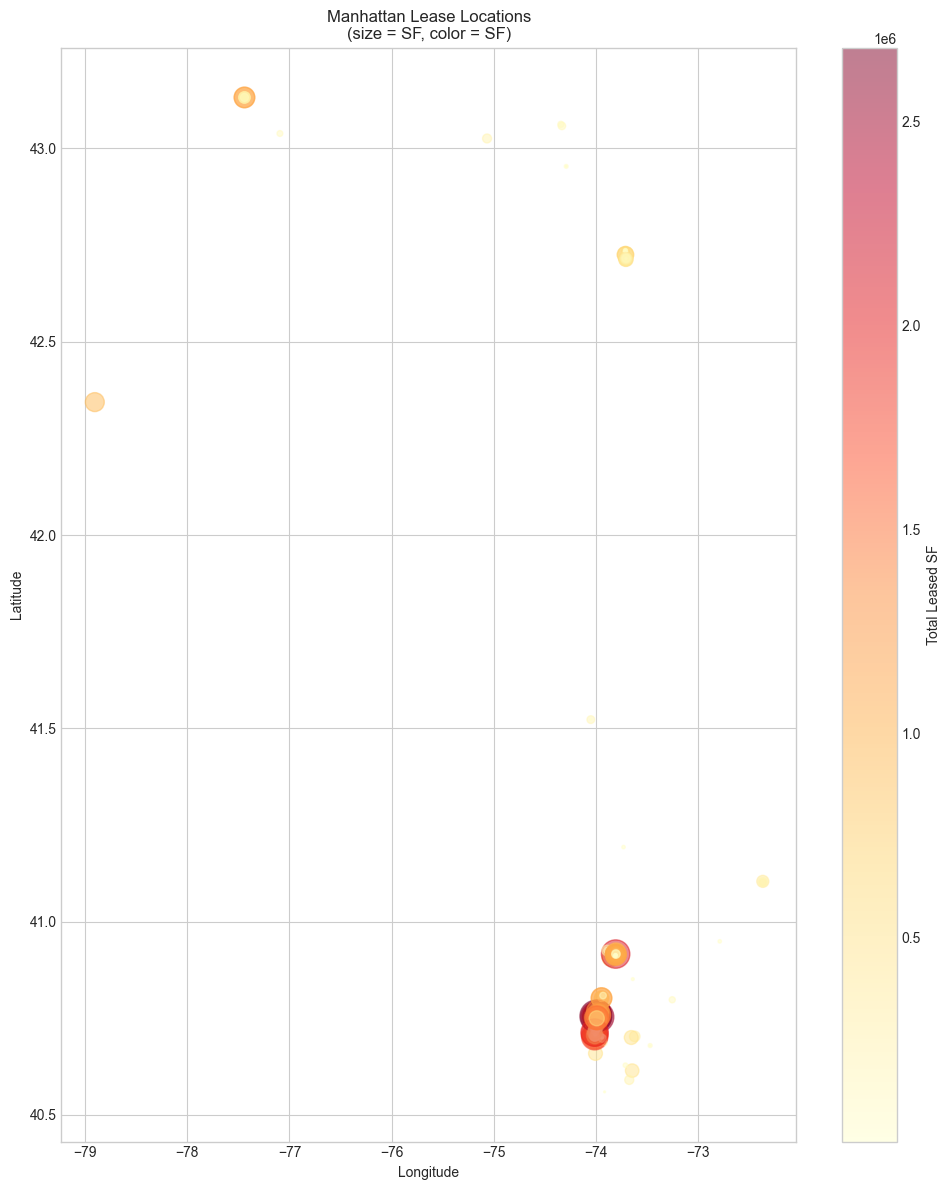

In [11]:
if buildings is not None:
    # Scatter plot of lease locations
    fig, ax = plt.subplots(figsize=(10, 12))
    
    sf_col = 'total_leasedSF' if 'total_leasedSF' in buildings.columns else 'leasedSF'
    
    scatter = ax.scatter(
        buildings['longitude'], 
        buildings['latitude'],
        c=buildings[sf_col],
        s=buildings[sf_col] / 5000,
        alpha=0.5,
        cmap='YlOrRd'
    )
    
    plt.colorbar(scatter, label='Total Leased SF')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Manhattan Lease Locations\n(size = SF, color = SF)')
    plt.tight_layout()
    plt.show()

## 7. Safety & Accessibility Scores

We enriched the data with:
- **Safety Score**: Inverse of crime density within 500m
- **Accessibility Score**: Transit route density (subway, bus)

In [12]:
if buildings is not None and 'safety_score' in buildings.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Safety distribution
    if 'safety_score' in buildings.columns:
        axes[0].hist(buildings['safety_score'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
        axes[0].set_xlabel('Safety Score (0 = riskier, 1 = safer)')
        axes[0].set_ylabel('Count')
        axes[0].set_title('Distribution of Safety Scores')
        axes[0].axvline(buildings['safety_score'].median(), color='red', linestyle='--', 
                       label=f"Median: {buildings['safety_score'].median():.2f}")
        axes[0].legend()
    
    # Accessibility distribution
    acc_col = [c for c in buildings.columns if 'access' in c.lower()]
    if acc_col:
        axes[1].hist(buildings[acc_col[0]].dropna(), bins=30, edgecolor='black', alpha=0.7, color='blue')
        axes[1].set_xlabel('Accessibility Score')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Distribution of Accessibility Scores')
    
    plt.tight_layout()
    plt.show()

## 8. Key Findings

### Market Insights:
1. **Lease Size**: Median lease is ~10,000 SF; most are small-medium
2. **Industry Mix**: Finance, Legal, and Technology dominate Manhattan CRE
3. **Building Class**: Class A commands ~40% premium over Class O
4. **Geography**: Midtown has highest density; Downtown growing

### Buyer Recommendations:
- **Small tenants (<5K SF)**: Focus on Class O buildings in emerging areas
- **Large tenants (>50K SF)**: Negotiate bulk discounts, target Class A for talent
- **Tech companies**: Consider Midtown South or FiDi for talent density
- **Law firms**: Traditional Midtown offers best accessibility for clients

## 9. Interactive Application

We built a Streamlit application that allows users to:
1. Filter properties by SF, safety, and accessibility
2. View properties on an interactive map
3. See market friendliness overlays by industry

**To run the app:**
```bash
cd app
streamlit run streamlit_app.py
```

## 10. Future Improvements

With more time/data, we could add:
- **Rent prediction model** using ML on historical data
- **Market trend analysis** for investment timing
- **Competitor analysis** showing where similar companies lease
- **Walk score integration** for employee commute analysis
- **Amenity scoring** (restaurants, gyms, etc. nearby)